## Astrostatistics Homework
In this homework we want to study a bivariate Gaussian with mean $\mu=(4,\, 2)$ and covariance matrix $\Sigma=\begin{pmatrix} 1.44 & -0.702 \\ -0.702 & 0.81 \end{pmatrix}$ that we assume to be the posterior distribution of the two parameters $X_1$ and $X_2$.

First of all, we want to plot the contours of the posterior and then indicate the $95\%$ credibility interval. To do so we first define all the necessary quantities such as $\mu$ and $\Sigma$, then we split the parameter space into a $(1000 \times 1000)$ grid for $X_1 \in [0,\, 8]$ and $X_2 \in [-1,\, 5]$, so that the important contours of the posterior are well inside the plot. After that, we stack the coordinates and evaluate the bivariate Gaussian PDF over the entire grid using scipy.stats.multivariate_normal. This gives us the posterior density values across parameter space. We then plot the density using contour lines and highlight the mean using the two dashed red lines.

In [ ]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

In [ ]:
# Defining the mean and covariance matrix for the bivariate gaussian distribution
mu = np.array([4, 2])
cov = np.array([[1.44, -0.702],
              [-0.702, 0.81]])

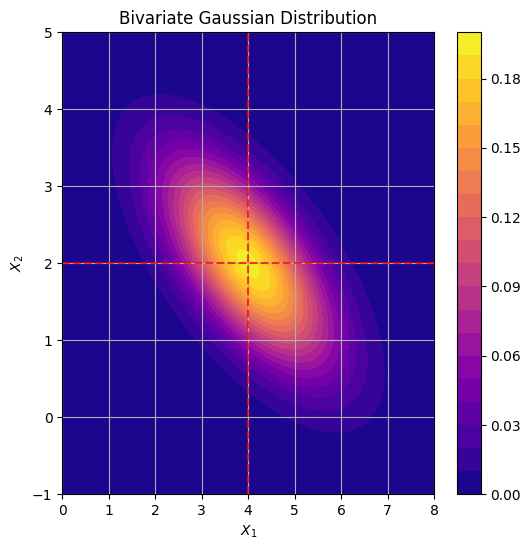

In [3]:
# Creating the grid to plot the bivariate gaussian
x1 = np.linspace(0, 8, 1000)
x2 = np.linspace(-1, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
pos = np.dstack((X1, X2))

# Computing the distribution
mvg=stat.multivariate_normal(mean=mu, cov=cov)
Z=mvg.pdf(pos)

# Plotting it and showing the position of the mean value
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, Z, levels=20, cmap='plasma')
plt.colorbar()
plt.title('Bivariate Gaussian Distribution')
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.axhline(mu[1], color="red", linestyle="--", alpha=0.75)
plt.axvline(mu[0], color="red", linestyle="--", alpha=0.75)
plt.grid()
plt.show()

The next step requires marginalizing over each parameter and finding the $95\%$ credibility interval; to do so, we can proceed by integrating over each parameter. Then the exercise requires finding again the same credibility interval, but this time by setting one of them as a constant and studying the other.

In [4]:
# Marginalizing by integrating over each parameter
margx1=np.trapezoid(Z, x2, axis=1)
margx2=np.trapezoid(Z, x1, axis=0)

# Computing the Cumulative Distribution Function
cdf_x1=np.cumsum(margx1)*(x1[1]-x1[0])
cdf_x2=np.cumsum(margx2)*(x2[1]-x2[0])

# Finding the 95% credible intervals
lower_x1=x1[np.searchsorted(cdf_x1, 0.025)]
upper_x1=x1[np.searchsorted(cdf_x1, 0.975)]
lower_x2=x2[np.searchsorted(cdf_x2, 0.025)]
upper_x2=x2[np.searchsorted(cdf_x2, 0.975)]

print(f"95% Credibility Interval for X1: [{lower_x1:.3f}, {upper_x1:.3f}]")
print(f"95% Credibility Interval for X2: [{lower_x2:.3f}, {upper_x2:.3f}]")

# Finding the Credibility Intervals by fixing each parameter
sigma_1=np.sqrt(cov[0, 0])  
sigma_2=np.sqrt(cov[1, 1])  
rho=cov[0, 1]/(sigma_1*sigma_2)

x1_fixed=4
x2_fixed=2

# Computing the conditional mean and variance of Xi given Xj = xj_fixed i,j=1,2, i different from j
mu_2_given_1=mu[1]+rho*(sigma_2/sigma_1)*(x1_fixed-mu[0])
sigma_2_given_1=sigma_2*np.sqrt(1-rho**2)
mu_1_given_2=mu[0]+rho*(sigma_1/sigma_2)*(x2_fixed-mu[1])
sigma_1_given_2= sigma_1*np.sqrt(1-rho**2)

# Computing the 95% credibility interval
credibility_intervalx2=np.round(stat.norm.interval(0.95, loc=mu_2_given_1, scale=sigma_2_given_1), 3)
credibility_intervalx1=np.round(stat.norm.interval(0.95, loc=mu_1_given_2, scale=sigma_1_given_2), 3)

print(f"95% Credibility Interval for X2 given a fixed X1 = {x1_fixed}: {credibility_intervalx2}")
print(f"95% Credibility Interval for X1 given a fixed X2 = {x2_fixed}: {credibility_intervalx1}")

95% Credibility Interval for X1: [1.666, 6.374]
95% Credibility Interval for X2: [0.249, 3.781]
95% Credibility Interval for X2 given a fixed X1 = 4: [0.66 3.34]
95% Credibility Interval for X1 given a fixed X2 = 2: [2.213 5.787]


Now the exercise asks to find the same boundaries by using Monte Carlo methods, more precisely, Cholesky, Metropolis-Hastings, and Gibbs.

For Cholesky, we need to decompose the covariance matrix $\Sigma$ using $\Sigma=LL^T$ using the command from numpy $\mathit{np.linalg.cholesky(cov)}$. After that we select to take $10^5$ samples and randomly generate them following a normal distribution. Now we need to correlate the two uncorrelated randomly correlated samples using the Cholesky factor $L$. In this way, the plot will show the correlation between the two parameters because of the tilt and the shape of the ellipse that it will generate in the parameter space. We finally compute the credibility intervals and plot everything. Since the exercise will require the same contour plot, it is better to define a function that later can be simply recalled and used to do so in a more efficient way. The exercise also requires plotting the histograms for the two parameters independently.

95% Confidence Intervals obtained by Cholesky decomposition of the covariance matrix:
- for X1: [1.64, 6.33];
- for X2: [0.24, 3.76].


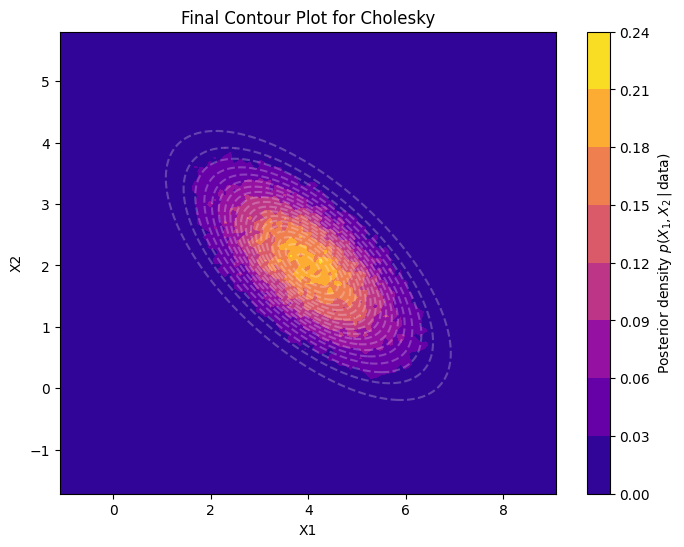

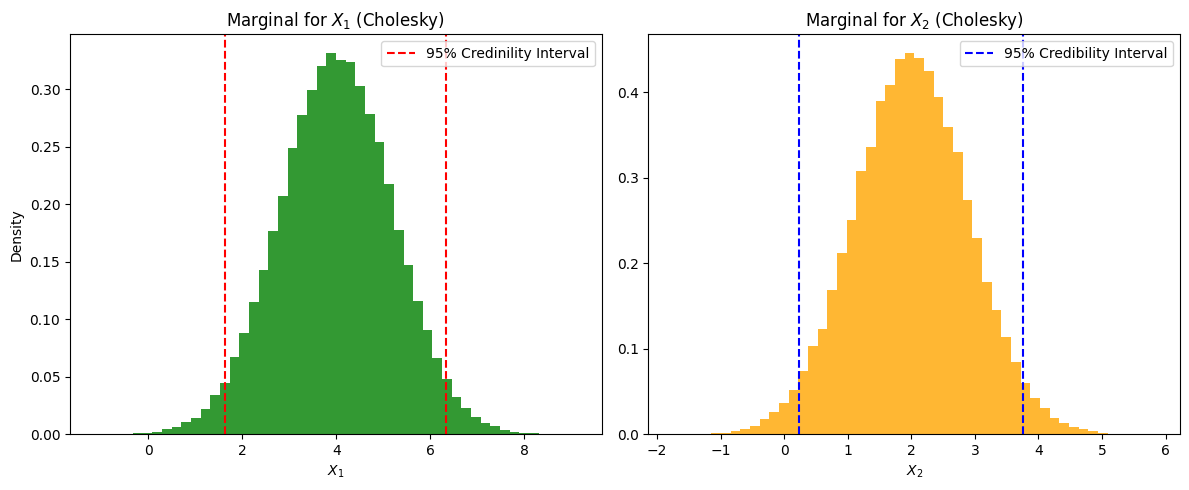

In [14]:
# a. Cholesky method
method="Cholesky"
L=np.linalg.cholesky(cov)
n_samples=100000
v=np.random.normal(size=(n_samples, 2))

# Transforming the samples using the Cholesky factor
samples_Cholesky=mu+v @ L.T

# Calculating the 95% confidence intervals
lower_bound=np.percentile(samples_Cholesky, 2.5, axis=0)
upper_bound=np.percentile(samples_Cholesky, 97.5, axis=0)

# Printing the confidence intervals
print(f"95% Confidence Intervals obtained by {method} decomposition of the covariance matrix:")
print(f"- for X1: [{lower_bound[0]:.2f}, {upper_bound[0]:.2f}];")
print(f"- for X2: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}].")

# Defining a function for the future plots
def f_contour_plot(samples, method, lower_bound, upper_bound):
    X1_samples=[x[0] for x in samples]
    X2_samples=[x[1] for x in samples]
    hist, x1edges, x2edges=np.histogram2d(X1_samples, X2_samples, bins=100, density=True)

    X1_S, X2_S=np.meshgrid((x1edges[:-1]+x1edges[1:])/2, (x2edges[:-1]+x2edges[1:])/2)


    # Plot using contourf
    plt.figure(1, figsize=(8, 6))
    plt.contourf(X1_S, X2_S, hist.T, cmap='plasma')
    plt.colorbar(label='Posterior density $p(X_1, X_2 \\,|\\,\\text{data})$')
    plt.contour(X1, X2, Z, levels=20, colors='white', linestyles='--', alpha=0.25)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f"Final Contour Plot for {method}")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram for X1
    axs[0].hist(X1_samples, bins=50, density=True, alpha=0.8, color='green')
    axs[0].axvline(lower_bound[0], linestyle='--', color='red', label='95% Credinility Interval')
    axs[0].axvline(upper_bound[0], linestyle='--', color='red')
    axs[0].set_title(f'Marginal for $X_1$ ({method})')
    axs[0].set_xlabel('$X_1$')
    axs[0].set_ylabel('Density')
    axs[0].legend()
    
    # Histogram for X2
    axs[1].hist(X2_samples, bins=50, density=True, alpha=0.8, color='orange')
    axs[1].axvline(lower_bound[1], linestyle='--', color='blue', label='95% Credibility Interval')
    axs[1].axvline(upper_bound[1], linestyle='--', color='blue')
    axs[1].set_title(f'Marginal for $X_2$ ({method})')
    axs[1].set_xlabel('$X_2$')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


f_contour_plot(samples_Cholesky, method, lower_bound, upper_bound)

The exercise now asks for the same procedure, but using Metropolis-Hastings as the sampling method. This method will require to plot and study also the traceplots to see how the sampling explored the posterior.

95% Confidence Intervals obtained by Metropolis-Hastings decomposition of the covariance matrix:
- for X1: [1.37, 5.93];
- for X2: [0.39, 3.92].


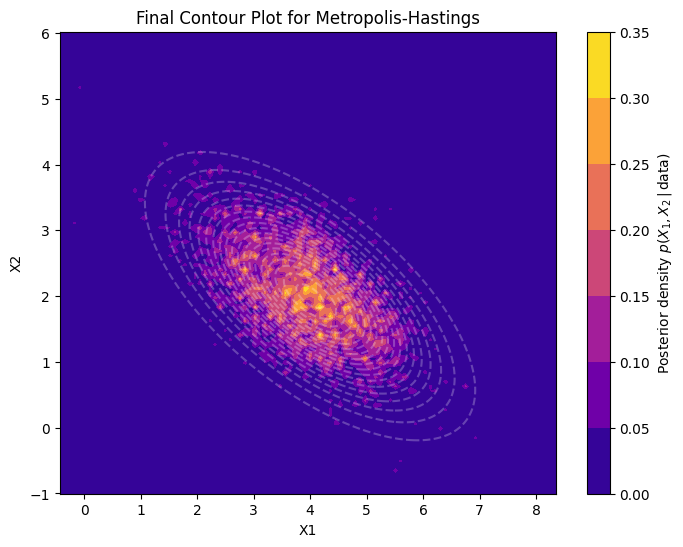

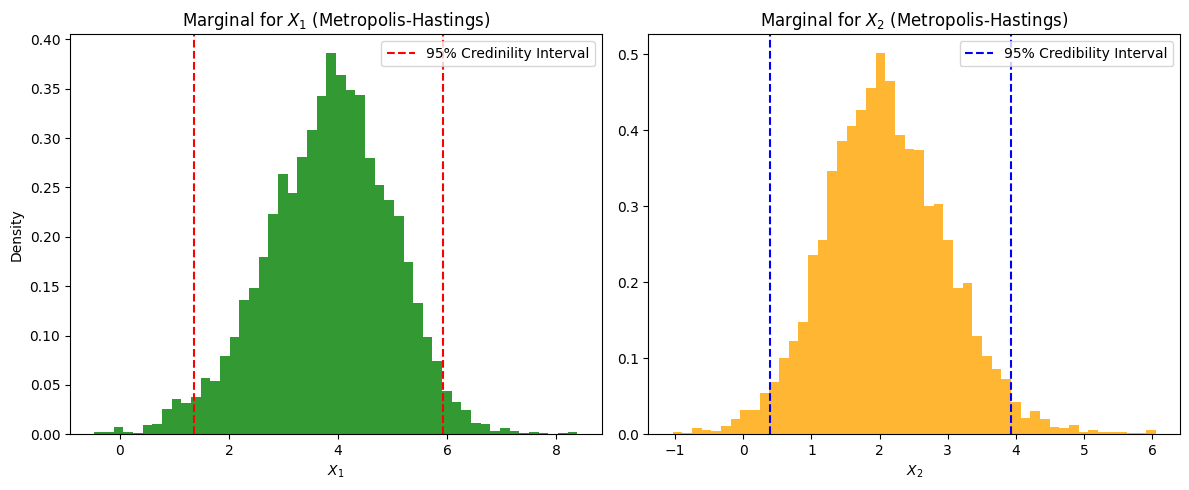

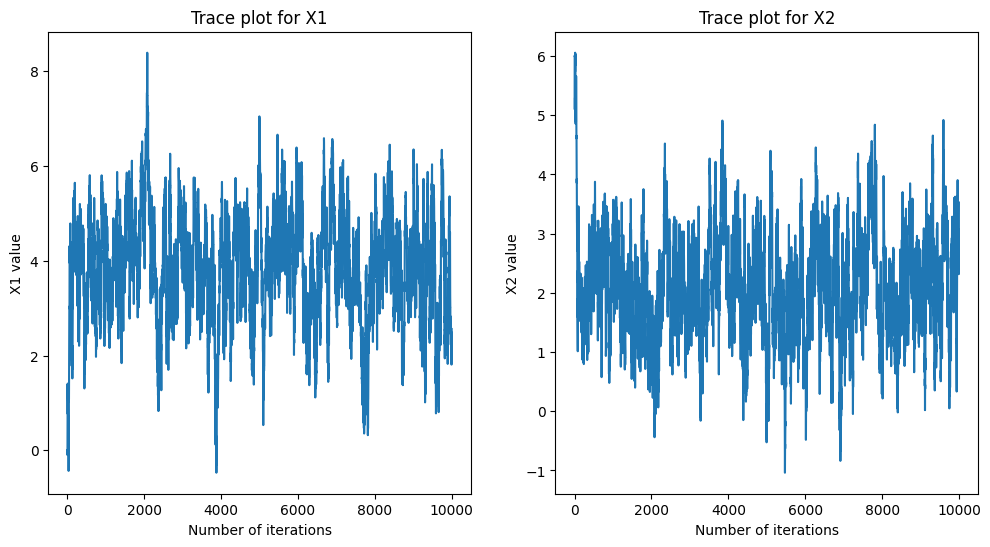

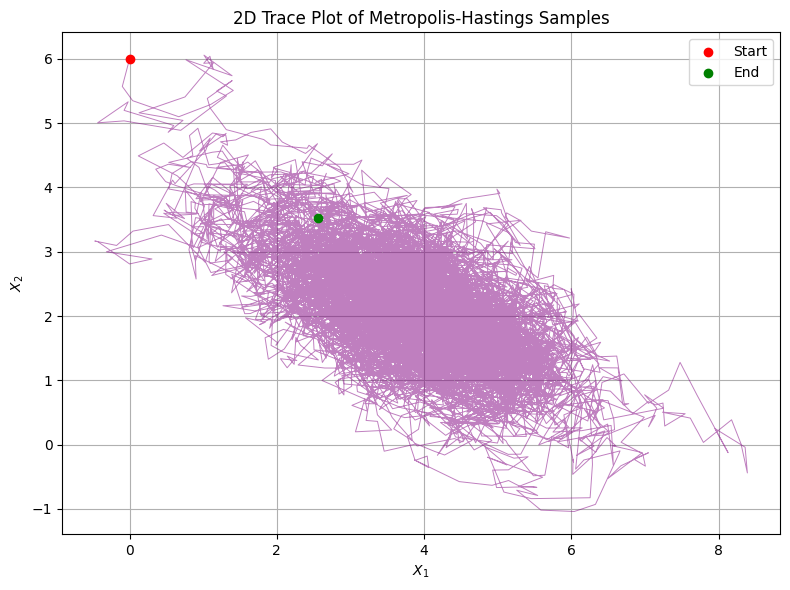

In [18]:
# b. Metropolis-Hastings
method='Metropolis-Hastings'

# Defining the algorithm
def bivariate_gaussian(x):
    return mvg.pdf(x)

def metropolis_hastings_bivariate(posterior, initial, proposal_std, iterations):

    current=np.array(initial)
    samples=[current]
    
    for _ in range(iterations):
        
        proposed=np.random.normal(current, proposal_std)
        
        acceptance_ratio=posterior(proposed)/posterior(current)
        acceptance_probability=min(1, acceptance_ratio)
        
        if np.random.rand() < acceptance_probability:
            current=proposed
       
        samples.append(current)
    
    return np.array(samples)

# Parameters
initial_guess = [0.0, 6.0]  
proposal_std = [0.3, 0.3]  
iterations = 10000 

# Metropolis-Hastings
samples_Metro_Hastings=metropolis_hastings_bivariate(bivariate_gaussian, initial_guess, proposal_std, iterations)

lower_bound=np.percentile(samples_Metro_Hastings, 2.5, axis=0)
upper_bound=np.percentile(samples_Metro_Hastings, 97.5, axis=0)

# Printing the confidence intervals
print(f"95% Confidence Intervals obtained by {method} decomposition of the covariance matrix:")
print(f"- for X1: [{lower_bound[0]:.2f}, {upper_bound[0]:.2f}];")
print(f"- for X2: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}].")

# Plotting the final contour, the marginalized posteriors and the trace plots
f_contour_plot(samples_Metro_Hastings, method, lower_bound, upper_bound)

MH_X1=samples_Metro_Hastings[:, 0]
MH_X2=samples_Metro_Hastings[:, 1]

fig, axs= plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(MH_X1)
axs[0].set_title('Trace plot for X1')
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('X1 value')
axs[1].plot(MH_X2)
axs[1].set_xlabel('Number of iterations')
axs[1].set_title('Trace plot for X2')
axs[1].set_ylabel('X2 value')
# Plot 2D trace
plt.figure(figsize=(8, 6))
plt.plot(MH_X1, MH_X2, color='purple', alpha=0.5, linewidth=0.7)
plt.scatter(MH_X1[0], MH_X2[0], color='red', label='Start', zorder=5)
plt.scatter(MH_X1[-1], MH_X2[-1], color='green', label='End', zorder=5)
plt.title('2D Trace Plot of Metropolis-Hastings Samples')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Finally, the same procedure with Gibbs sampling. As Metropolis-Hastings, this method requires studying the trace plots to check for correct mixing and convergence.

95% Confidence Intervals obtained by Gibbs decomposition of the covariance matrix:
- for X1: [1.73, 6.31];
- for X2: [0.17, 3.61].


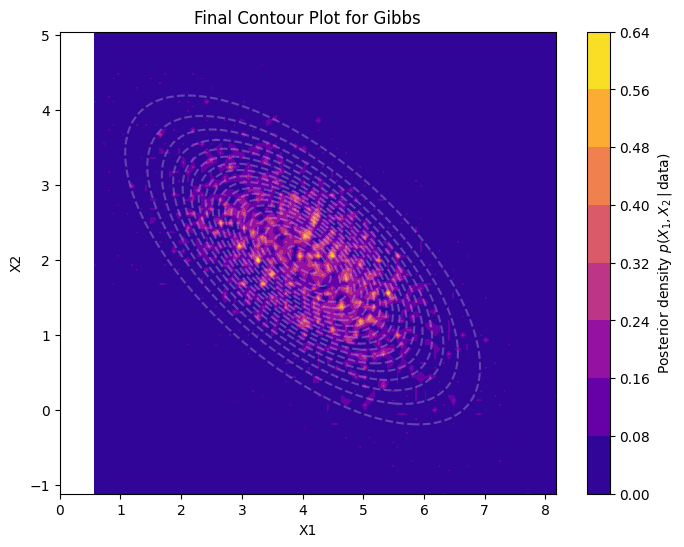

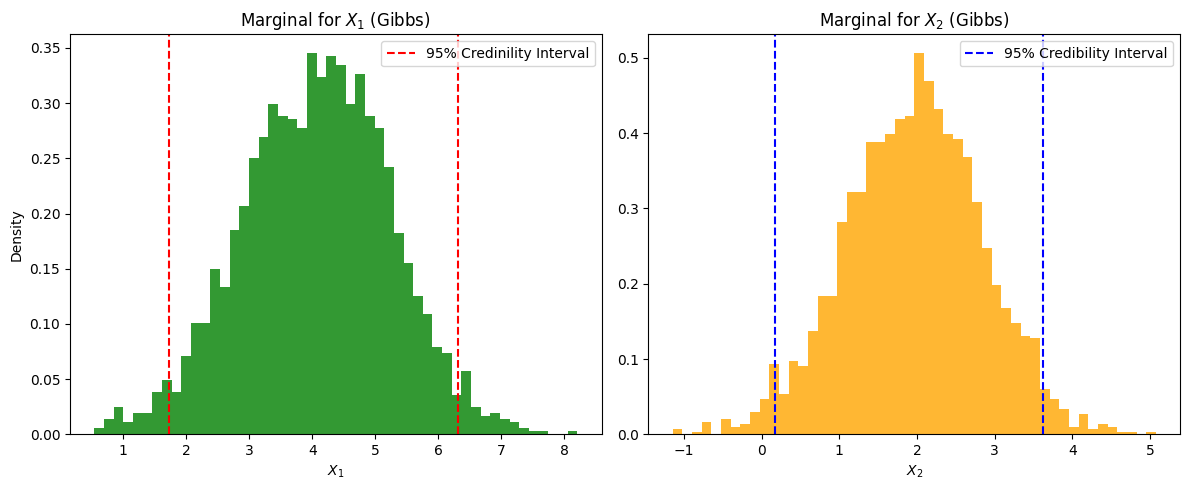

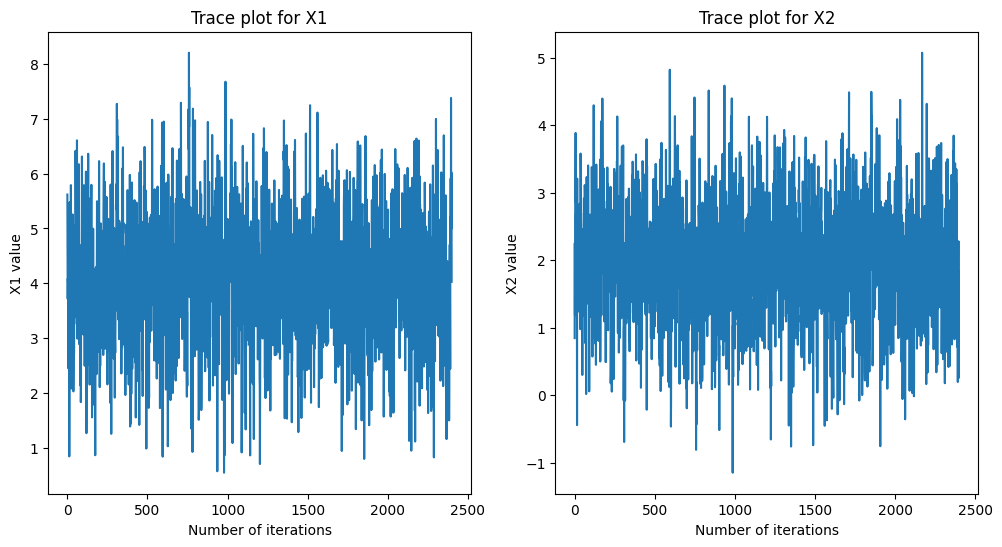

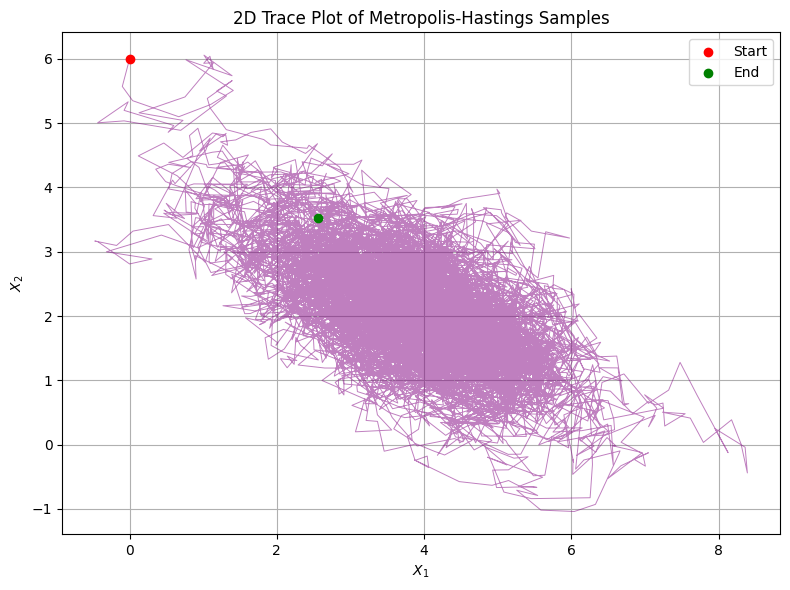

In [20]:
# c. Gibbs
method='Gibbs'

# Defining the algorithm
sigma_x1_given_x2=np.sqrt(cov[0, 0]-cov[0, 1]**2/cov[1, 1])
sigma_x2_given_x1=np.sqrt(cov[1, 1]-cov[1, 0]**2/cov[0, 0])

def gibbs_sampling(initial, iterations, burn_in):
    x1, x2=initial
    samples=[]

    for _ in range(iterations):
        
        mean_x1_given_x2=mu[0]+cov[0, 1]/cov[1, 1]*(x2-mu[1])
        x1=np.random.normal(mean_x1_given_x2, sigma_x1_given_x2)

        mean_x2_given_x1=mu[1]+cov[1, 0]/cov[0, 0]*(x1-mu[0])
        x2=np.random.normal(mean_x2_given_x1, sigma_x2_given_x1)

        samples.append([x1, x2])
    return np.array(samples[burn_in:])

# Parameters
initial_guess=[0.0, 0.0]
iterations=2500
burn_in=100

# Gibbs sampling
samples_Gibbs=gibbs_sampling(initial_guess, iterations, burn_in)

lower_bound=np.percentile(samples_Gibbs, 2.5, axis=0)
upper_bound=np.percentile(samples_Gibbs, 97.5, axis=0)

# Printing the confidence intervals
print(f"95% Confidence Intervals obtained by {method} decomposition of the covariance matrix:")
print(f"- for X1: [{lower_bound[0]:.2f}, {upper_bound[0]:.2f}];")
print(f"- for X2: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}].")

# Plotting the final contour, the marginalized posteriors and the trace plots
f_contour_plot(samples_Gibbs, method, lower_bound, upper_bound)

G_X1=samples_Gibbs[:, 0]
G_X2=samples_Gibbs[:, 1]

fig, axs=plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(G_X1)
axs[0].set_title('Trace plot for X1')
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('X1 value')
axs[1].plot(G_X2)
axs[1].set_xlabel('Number of iterations')
axs[1].set_title('Trace plot for X2')
axs[1].set_ylabel('X2 value')
# Plot 2D trace
plt.figure(figsize=(8, 6))
plt.plot(MH_X1, MH_X2, color='purple', alpha=0.5, linewidth=0.7)
plt.scatter(MH_X1[0], MH_X2[0], color='red', label='Start', zorder=5)
plt.scatter(MH_X1[-1], MH_X2[-1], color='green', label='End', zorder=5)
plt.title('2D Trace Plot of Metropolis-Hastings Samples')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()